<div style="text-align:center">
    <h1>
        Advantage Actor-Critic (A2C)
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods. The resulting algorithm is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy:
</div>

\begin{equation}
\hat G_t = R_{t+1} + \gamma v(S_{t+1}|w)
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [ ]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [ ]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

In [ ]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [ ]:
num_envs = os.cpu_count()

### Prepare the environment to work with PyTorch

In [ ]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [ ]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

### Create the value network $v(s)$

## Implement the algorithm

</br>

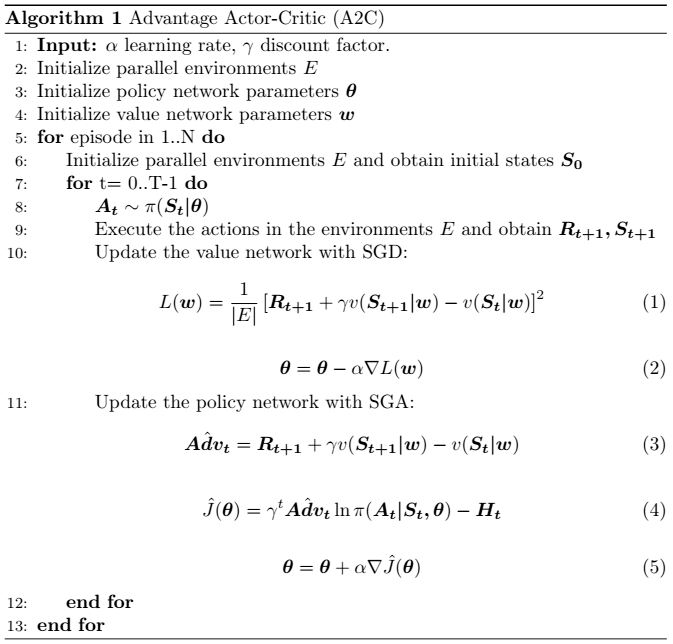

## Show results

### Show execution stats

In [ ]:
plot_stats(stats)

### Test the resulting agent

In [ ]:
test_policy_network(env, policy, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)